In [1]:
# input image
# detect text boxes
# detect text
# return text and positions

In [1]:
import sys
import os

from PIL import Image
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import time
from collections import OrderedDict
import numpy as np
import torch
import torchvision.transforms as transforms
from dotmap import DotMap

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from craft import CRAFT
import imgproc
import craft_utils

from ocr_model import Model
from ocr_dataset import RawDataset, AlignCollate
from ocr_utils import CTCLabelConverter, AttnLabelConverter

In [2]:
def is_timer_text(pred_text):
        
    if len(pred_text) != 4:
        return False
    # end
    
    for single_char in pred_text:
        if not RepresentsInt_MakeO0(single_char):
            return False
        # end
    # end       
    
    return True
# end

def is_period_text(pred_text):
        
    if len(pred_text) != 3:
        return False
    # end
    
    if not RepresentsInt_MakeO0(pred_text[0]):
        return False
    # end
    
    if not is_all_chars(pred_text[1:]):
        return False
    # end    
    
    return True
# end

def is_all_chars(pred_text):
    is_all_char = True
    for temp_char in pred_text:
        if RepresentsInt(temp_char):
            is_all_char = False
            break
        # end
    #end
    
    return is_all_chars
# end

def GetInt(s):
    try: 
        val = int(s)
        return val
    except ValueError:
        if s == 'o':
            return 0
        # end
        return -1
    # end
# end

def RepresentsInt_MakeO0(s):
    try: 
        int(s)
        return True
    except ValueError:
        if s == 'o':
            return True
        # end
        return False
    # end
# end

def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
# end

def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict
# end

def init_craft():
     # load net
    net = CRAFT()     # initialize
    str_trained_model_path = 'dmodel/craft_mlt_25k.pth'
    net.load_state_dict(copyStateDict(torch.load(str_trained_model_path)))
    
    if True:
        net = net.cuda()
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = False

    net.eval()
    
    return net
# end

def test_net(net, image, text_threshold, link_threshold, low_text, cuda, canvas_size, show_time,mag_ratio):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    y, _ = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()
    
    # Post-processing
    boxes = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text)
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)

    t1 = time.time() - t1
    
    if show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes
# end

def init_ocr(opt):
    """ model configuration """
    if 'CTC' in opt['Prediction']:
        converter = CTCLabelConverter(opt['character'])
    else:
        converter = AttnLabelConverter(opt['character'])
    opt['num_class'] = len(converter.character)

    if opt['rgb']:
        opt['input_channel'] = 3
    model = Model(opt)
    print('model input parameters', opt['imgH'], opt['imgW'], opt['num_fiducial'], opt['input_channel'], opt['output_channel'],
          opt['hidden_size'], opt['num_class'], opt['batch_max_length'], opt['Transformation'], opt['FeatureExtraction'],
          opt['SequenceModeling'], opt['Prediction'])

    model = torch.nn.DataParallel(model)
    if torch.cuda.is_available():
        model = model.cuda()

    # load model
    print('loading pretrained model from %s' % opt['saved_model'])
    model.load_state_dict(torch.load(opt['saved_model']))

    # prepare data. two demo images from https://github.com/bgshih/crnn#run-demo
    # sai removed here

    # predict
    model.eval()
    
    return (model, converter)
# end    

def run_ocr(model, converter, image_tensors, opt):    
    batch_size = image_tensors.size(0)
    with torch.no_grad():
        image = image_tensors.cuda()
        # For max length prediction
        length_for_pred = torch.cuda.IntTensor([opt['batch_max_length']] * batch_size)
        text_for_pred = torch.cuda.LongTensor(batch_size, opt['batch_max_length'] + 1).fill_(0)

    if 'CTC' in opt['Prediction']:
        preds = model(image, text_for_pred).log_softmax(2)

        # Select max probabilty (greedy decoding) then decode index to character
        preds_size = torch.IntTensor([preds.size(1)] * batch_size)
        _, preds_index = preds.permute(1, 0, 2).max(2)
        preds_index = preds_index.transpose(1, 0).contiguous().view(-1)
        preds_str = converter.decode(preds_index.data, preds_size.data)

    else:
        preds = model(image, text_for_pred, is_train=False)

        # select max probabilty (greedy decoding) then decode index to character
        _, preds_index = preds.max(2)
        preds_str = converter.decode(preds_index, length_for_pred)
    # end

    # print('-' * 80)
    # print('image_path\tpredicted_labels')
    # print('-' * 80)
    
    pred_str_arr = []
    
    for index, pred in enumerate(preds_str):
        if 'Attn' in opt['Prediction']:
            pred = pred[:pred.find('[s]')]  # prune after "end of sentence" token ([s])
        # end
        pred_str_arr.append(pred)
        # print('img_name<',index, '> pred<',pred, '>')
    # end
    
    return pred_str_arr
# end

def preprocess_and_convert_to_tensorsarr(img_arr, tw, th):
    image_tensors = []
    for img in img_arr:
        img = Image.fromarray(img)
        img = img.resize((tw, th), Image.BICUBIC)
        img = transforms.ToTensor()(img)
        img.sub_(0.5).div_(0.5)
        image_tensors.append(img)
    # end
    
    image_tensors = torch.cat([t.unsqueeze(0) for t in image_tensors], 0)
    
    return image_tensors
# end

In [13]:
def process_image(image):

    qtr_img = image[0:int(image.shape[0]/8), 0:image.shape[1]]      
    bboxes = test_net(net, qtr_img, text_threshold, link_threshold, low_text, cuda, canvas_size, show_time, mag_ratio)

    b_plot = True
    len_boxes = len(bboxes)
    crop_img_arr = []

    for index, box in enumerate(bboxes):

        box = box.astype(np.int32)
        x = box[0][0]
        w = box[1][0]-box[0][0]
        y = box[0][1]
        h = box[3][1]-box[0][1]

        delta = 0
        x = x - delta
        y = y - delta
        w = w + 2*delta
        h = h + 2*delta

        if x < 0 or y < 0 or x+w > image.shape[1] or y+h > image.shape[0]:
            continue
        # end                   

        crop_img = image[y:y+h, x:x+w]   
        # crop_img_arr.append(crop_img)
        crop_img_arr.append(cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY))

        if b_plot:    
            plt.subplot(len_boxes, 1, index+1)
            plt.imshow(crop_img)
        # end

    # end

    if b_plot:
        plt.show()
    # end   
    
    if len_boxes == 0 or len(crop_img_arr) == 0:
        return ([], [])
    # end

    image_tensors = preprocess_and_convert_to_tensorsarr(crop_img_arr, opt['imgW'], opt['imgH'])

    pred_text_arr = run_ocr(ocr_model, ocr_converter, image_tensors, opt)
    
    if len(pred_text_arr) != len_boxes:
        print('boxes len<', len_boxes, '> pred len<', len(pred_text_arr), '>')
        # raise('pred and boxes dont match. Not expected to come here')
        return ([],[])
    # end        
    
    return (bboxes, pred_text_arr)
# end

In [5]:
def find_boxes_in_straight_line(bboxes, delta_error):
    mean_pts = []
    last_y = 0
    pts_in_line_arr = []
    scoreboard_bboxes = []
    for index, bbox in enumerate(bboxes):
        mean_pt = [0, 0]
        for pt in bbox:
            mean_pt[0] += pt[0]
            mean_pt[1] += pt[1]
        # end
        mean_pt[0] = mean_pt[0]/4
        mean_pt[1] = mean_pt[1]/4
        
        if mean_pt[1] - last_y > delta_error:
            # assumption points are ordered by x
            pts_in_line_arr.append(scoreboard_bboxes)
            scoreboard_bboxes = []
            last_y = mean_pt[1]
        # end
        scoreboard_bboxes.append(index)        
        mean_pts.append(mean_pt)
    # end
    
    pts_in_line_arr.append(scoreboard_bboxes)    
    
    return  pts_in_line_arr
# end

def convert_bbox_rect(box):
    box = box.astype(np.int32)
    x = box[0][0]
    w = box[1][0]-box[0][0]
    y = box[0][1]
    h = box[3][1]-box[0][1]
    return [x, y, w, h]
# end

def is_scoreboard_2(pts_in_line, bboxes, pred_text_arr):
    if len(pts_in_line) != 6:
        return ({},{})
    # end

    if not is_all_chars(pred_text_arr[pts_in_line[0]]):
        # t1_name is expected to be all strings
        return {}
    # end

    if not RepresentsInt_MakeO0(pred_text_arr[pts_in_line[1]]):
        # t1_score is expected to be int
        return ({},{})
    # end

    if not is_period_text(pred_text_arr[pts_in_line[2]]):
        # period expected to match the template
        return ({},{})
    # end
    
    if not is_timer_text(pred_text_arr[pts_in_line[3]]):
        # timer is expected to be 4 numbers 
        return ({},{})
    # end

    if not RepresentsInt_MakeO0(pred_text_arr[pts_in_line[4]]):
        # t2_score is expected to be int
        return ({},{})
    # end

    if not is_all_chars(pred_text_arr[pts_in_line[5]]):
        # t2_name is expected to be all strings
        return ({},{})
    # end

   

    scoreboard_bbox = {
    't1_name': convert_bbox_rect(bboxes[pts_in_line[0]]),
    't1_score': convert_bbox_rect(bboxes[pts_in_line[1]]),
    't2_name': convert_bbox_rect(bboxes[pts_in_line[5]]),
    't2_score': convert_bbox_rect(bboxes[pts_in_line[4]]),
    'period': convert_bbox_rect(bboxes[pts_in_line[2]]),
    'timer': convert_bbox_rect(bboxes[pts_in_line[3]])        
    }
    
    scoreboard_values = {
    't1_name': pred_text_arr[pts_in_line[0]],
    't1_score': GetInt(pred_text_arr[pts_in_line[1]]),
    't2_name': pred_text_arr[pts_in_line[5]],
    't2_score': GetInt(pred_text_arr[pts_in_line[4]]),
    'period': pred_text_arr[pts_in_line[2]],
    'timer': pred_text_arr[pts_in_line[3]]        
    }
    
    return (scoreboard_bbox, scoreboard_values)
# end

def is_scoreboard_1(pts_in_line, bboxes, pred_text_arr):
    if len(pts_in_line) != 6:
        return ({},{})
    # end

    if not is_all_chars(pred_text_arr[pts_in_line[0]]):
        # t1_name is expected to be all strings
        return {}
    # end

    if not RepresentsInt_MakeO0(pred_text_arr[pts_in_line[1]]):
        # t1_score is expected to be int
        return ({},{})
    # end

    if not is_period_text(pred_text_arr[pts_in_line[2]]):
        # period expected to match the template
        return ({},{})
    # end

    if not RepresentsInt_MakeO0(pred_text_arr[pts_in_line[3]]):
        # t2_score is expected to be int
        return ({},{})
    # end

    if not is_all_chars(pred_text_arr[pts_in_line[4]]):
        # t2_name is expected to be all strings
        return ({},{})
    # end

    if not is_timer_text(pred_text_arr[pts_in_line[5]]):
        # timer is expected to be 4 numbers 
        return ({},{})
    # end

    scoreboard_bbox = {
    't1_name': convert_bbox_rect(bboxes[pts_in_line[0]]),
    't1_score': convert_bbox_rect(bboxes[pts_in_line[1]]),
    't2_name': convert_bbox_rect(bboxes[pts_in_line[4]]),
    't2_score': convert_bbox_rect(bboxes[pts_in_line[3]]),
    'period': convert_bbox_rect(bboxes[pts_in_line[2]]),
    'timer': convert_bbox_rect(bboxes[pts_in_line[5]])        
    }
    
    scoreboard_values = {
    't1_name': pred_text_arr[pts_in_line[0]],
    't1_score': GetInt(pred_text_arr[pts_in_line[1]]),
    't2_name': pred_text_arr[pts_in_line[4]],
    't2_score': GetInt(pred_text_arr[pts_in_line[3]]),
    'period': pred_text_arr[pts_in_line[2]],
    'timer': pred_text_arr[pts_in_line[5]]        
    }
    
    return (scoreboard_bbox, scoreboard_values)
# end

def did_match(pts_in_line_arr, bboxes, pred_text_arr):
    
    res = ({}, {})
    
    for pts_in_line in pts_in_line_arr:
        res_1 = is_scoreboard_1(pts_in_line, bboxes, pred_text_arr)           
        res_2 = is_scoreboard_2(pts_in_line, bboxes, pred_text_arr)           
        if res_1 != ({}, {}):
            res = res_1
        elif res_2 != ({}, {}):
            res = res_2
        # end        
    # end
    
    return res
    
# end

In [6]:
text_threshold = 0.7
low_text = 0.4
link_threshold = 0.4
canvas_size = 1280
mag_ratio = 1.5
cuda = True
show_time = False
no_of_matches_required_for_team_names = 20
skip_delta_in_secs = 10
i_print_frequency = 100
max_pos_error = 2

opt = DotMap({
    'imgW': 100,
    'imgH': 32,
    'workers' : 4,
    'batch_size' : 192,
    'saved_model' : 'dmodel/TPS-ResNet-BiLSTM-Attn.pth',
    'batch_max_length' : 25  ,
    'rgb' : False,
    'character' :'0123456789abcdefghijklmnopqrstuvwxyz',
    'sensitive' : False ,
    'PAD' : False,
    'Transformation' : 'TPS',
    'FeatureExtraction' : 'ResNet',
    'SequenceModeling' : 'BiLSTM',
    'Prediction' : 'Attn',
    'num_fiducial' : 20,
    'input_channel' : 1,
    'output_channel' : 512,
    'hidden_size' : 256,
    'num_gpu' : torch.cuda.device_count()
})

cudnn.benchmark = True
cudnn.deterministic = True

In [7]:
net = init_craft()
ocr_model, ocr_converter = init_ocr(opt)

model input parameters 32 100 20 1 512 256 38 25 TPS ResNet BiLSTM Attn
loading pretrained model from dmodel/TPS-ResNet-BiLSTM-Attn.pth


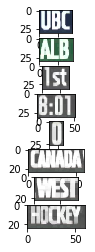

['ubc', 'alb', '1st', '801', '0', 'canada', 'west', 'hockey']


In [34]:
# image = imgproc.loadImage('/mnt/disks/d1/s/code/sih/score_extraction/tempcandelete_15-20190407-game12/frame_213011.jpg')
image = imgproc.loadImage('/mnt/disks/d1/s/data/apra/tempcandelete/alb_1800.jpg')
kernel = np.ones((3,3),np.uint8)
dilation = cv2.dilate(image,kernel,iterations = 1)
erosion = cv2.erode(image,kernel,iterations = 1)
dilation2 = cv2.dilate(erosion,kernel,iterations = 1)
out = process_image(dilation)
print(out[1])

In [ ]:
pts_in_line_arr = find_boxes_in_straight_line(out[0], 10)
did_match(pts_in_line_arr, out[0], out[1])

In [ ]:
video_fullpath = '/mnt/disks/d1/s/data/apra/source/15-20190407-game12_source.mp4'
t1_name = 'WAIN'
t2_name = 'ADR'

# net = init_craft()
# ocr_model, ocr_converter = init_ocr(opt)

v=cv2.VideoCapture(video_fullpath)

i_counter = 0
i_offset_in_secs = 1800 # offset in seconds 

# State Variables
cur_team_1_score = 0
cur_team_2_score = 0
team_1_score_history = {} 
team_2_score_history = {}

while True:
    i_counter += 1
    v.set(cv2.CAP_PROP_POS_MSEC, i_offset_in_secs*1000)
    ret, frame = v.read()    
    if ret != True:
        break
    # end
    
    img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    bboxes, pred_text_arr = process_image(frame, t1_name, t2_name)
    
    if i_counter % i_print_frequency == 0:
        print('processed<', i_counter, '> offset<', i_offset_in_secs, '>')
    # end    
    
    if len(bboxes) == 0:
        i_offset_in_secs += skip_delta_in_secs    
        continue
    # end
    
    pts_in_line_arr = find_boxes_in_straight_line(bboxes, 10)        
    scoreboard_bbox, scoreboard_values = did_match(pts_in_line_arr, bboxes, pred_text_arr)
    
    if scoreboard_bbox == {}:
        i_offset_in_secs += skip_delta_in_secs    
        continue
    # end
    
    if cur_team_1_score != scoreboard_values['t1_score']:
        
        if scoreboard_values['t1_score'] - cur_team_1_score != 1:
            print('t1_score_error prev_score<', cur_team_1_score, '> new_det_score<', scoreboard_values['t1_score'], '>')
        # end        
        cv2.imwrite('scorechanges/'+ video_fullpath.split('_source')[0] + '_'+str(i_offset_in_secs).zfill(10)+'.jpg', frame)
        team_1_score_history[i_offset_in_secs] = scoreboard_values['t1_score']
        cur_team_1_score = scoreboard_values['t1_score']
    # end
    
    if cur_team_2_score != scoreboard_values['t2_score']:
        if scoreboard_values['t2_score'] - cur_team_2_score != 1:
            print('t2_score_error prev_score<', cur_team_2_score, '> new_det_score<', scoreboard_values['t2_score'], '>')
        # end
        cv2.imwrite('scorechanges/'+ video_fullpath.split('_source')[0] + '_'+str(i_offset_in_secs).zfill(10)+'.jpg', frame)
        team_2_score_history[i_offset_in_secs] = scoreboard_values['t2_score']
        cur_team_2_score = scoreboard_values['t2_score']
    # end                   
    
    i_offset_in_secs += skip_delta_in_secs    
# end

print('Completed. Processed<', i_counter, '> offset<', i_offset_in_secs, '>')
print(team_1_score_history)
print(team_2_score_history)

boxes len< 8 > pred len< 7 >
processed< 100 > offset< 2790 >
processed< 200 > offset< 3790 >
processed< 300 > offset< 4790 >
boxes len< 10 > pred len< 9 >
processed< 400 > offset< 5790 >
processed< 500 > offset< 6790 >
boxes len< 9 > pred len< 8 >
processed< 600 > offset< 7790 >


- [ ] Run for all videos
- [ ] Run for entire video
- [ ] Find Start Game
- [ ] Find End Game
- [ ] Track Scoreboard
- [ ] Track the 3 periods
- [ ] Track No Scoreboard times
- [ ] Sanity check - Scoreboard Location should not deviate by much and the team names should be same
- [ ] Allow for some misdetections - smoothing window